In [112]:
from bs4 import * # Importing BeautifulSoup
import requests as rq 
from newspaper import Article # Importing newspaper3k
import json
import nltk # Importing nltk for NLP
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anicha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [102]:
# Fetching URLs for all the news from Indian Express website
r = rq.get("https://indianexpress.com/section/india/")
soup = BeautifulSoup(r.text, "html.parser")
ind_exp = []
for value in soup.find_all("a"):
    ind_exp.append(value.get('href'))

In [104]:
ind_exp_final = []

In [105]:
# Data Cleaning
# This is to remove any links that belong to advertisments, etc.
for link in ind_exp:
    if(link.startswith('https://indianexpress.com/article')):
        ind_exp_final.append(link)

In [133]:
# Iterating through the list of links and using the newspaper module to obtain information about each article
data = []
for link in ind_exp_final:
    article = Article(link)
    article.download()
    article.parse()
    article.nlp()
    data.append({
        "title": article.title,
        "authors": article.authors,
        "publish_date": str(article.publish_date),
        "keywords": article.keywords,
    }
                     )

In [109]:
# Storing all the data collected in a JSON file
with open ('data_ind_exp2.json', 'w') as outfile:
    json.dump(data, outfile)

In [118]:
# I converted the JSON to CSV on https://json-csv.com/ and used the resultant CSV file (I can directly use JSON to create the 
# dataframe, but this CSV convertor splits the keywords list automatically, 
# so it will reduce some steps in my data cleaning process)
df2 = pd.read_csv('data2.csv') 
# Most of the articles have only 12 keywords, so dropping the rest of the columns
df3 = df2.drop(['keywords__013','keywords__014','keywords__015','keywords__016','keywords__017','keywords__018','keywords__019','keywords__020'], axis=1)
# Newspaper hasn't been able to retrieve authors for most of the articles. So dropping authors
df4 = df3.drop(['authors__001','authors__002','authors__003'], axis=1)
# When I used BeautifulSoup to retrieve the links, some of them were repeated. So, removing duplicates
df4.drop_duplicates(subset= 'title',keep='first',inplace=True)
# Title and keywords have most of the same words. So, dropping title
df5 = df4.drop(['title'],axis=1)

In [134]:
# Splitting the date into year, month, day and hour for easy interpretation
publish_year = []
publish_month = []
publish_day = []
publish_hour = []

for date in df5['publish_date']:
    date = date.strip('+05:30')
    date_split = date.split(":")
    new_date = date_split[0]
    display(new_date)
    date =  datetime.strptime(new_date, '%Y-%m-%d %H')
    publish_year.append(date.year)
    publish_month.append(date.month)
    publish_day.append(date.day)
    publish_hour.append(date.hour)
df5['publish_year'] = publish_year
df5['publish_month'] = publish_month
df5['publish_day'] = publish_day
df5['publish_hour'] = publish_hour
df5.head()
df6 = df5.drop(['publish_date'],axis = 1)

In [121]:
# Making a dictonary of all the unique keywords encountered. The word is used as the key and a number is allotted to it as its value
words = np.concatenate((df6['keywords__001'].values,df6['keywords__002'].values,df6['keywords__003'].values,df6['keywords__004'].values,df6['keywords__005'].values,df6['keywords__006'].values,df6['keywords__007'].values,df6['keywords__008'].values,df6['keywords__009'].values,df6['keywords__010'].values,df6['keywords__011'].values,df6['keywords__012'].values))
i = 1
dict = {}
for word in words:
    dict.update({word: i})  # This adds to the dictionary and if a key that has already been assigned is encountered, then it updates the value
    i+=1

In [123]:
# All the keywords in the dataframe are replaced with the number that has been allotted to them in dict
df7 = df6.applymap(lambda s: dict.get(s) if s in dict else s)

In [125]:
# Normalizing all the data in the dataframe
df8=(df7-df7.mean())/df7.std() 

In [128]:
# Applying the K-Means Clustering algorithm
dataset = df8.values # Converting the dataframe into a matrix because KMeans deals only with matrices
kmeans = KMeans(n_clusters=2) # Initiating KMeans by feeding number of clusters
kmeans.fit(dataset) # Supplying the data set that it has to fit for
labels = kmeans.labels_ # The array of predictions. All the data points have been allotted either 1 or 0
results = pd.DataFrame([df8.index,labels]).T # A dataframe displaying the index number and the corresponding label

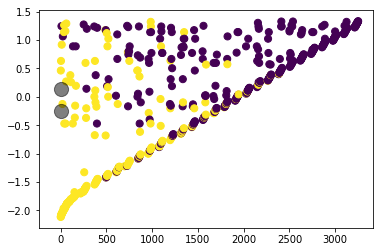

In [139]:
# Scatter plot of the clusters. y-axis: normalized value corresponding to keyword__012: x-axis: index number. 
plt.scatter(results.values[:, 0], dataset[:, 11], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
# Now to be able to predict which of these clusters corresponds to articles that will go viral and which corresponds to articles 
# that won't, I have made an assumption that articles related to the coronavirus are probably more viewed than the others. 
# Looking at dict to find the value corresponding to coronavirus, and looking at the occurrence of it in df7, 
# I observed that the first article's keyword__012 is coronavirus.
# Looking at df8, this corresponds to a normalized value of around -2.
# So, in our scatter plot, the region near (0,-2) represents that article. 
# This region is mostly surrounded by yellow spots. So, I have concluded that the yellow spots correspond to viral articles. 
# This corresonds to a label of 1.
# Therefore, those articles that are labelled 1 (yellow) are the ones that my model preicts to be viral.

In [ ]:
# Of course many assumptions have been made here and this prediction may not be totally true. 
# Some major drawbacks of my approach:
# I have taken data only from one website. This is not an ideal data set and an ideal data set needs to have more diversity
# A few more parameters should ideally be considered when trying to find out if a certain article is viral or not. 
# Authors and titles will have a big role to play, but have not been used here for the reasons stated above.
# Before concluding that the label 1 corresponds to viral articles, a little more testing should be done. 
# Feeding in articles that we know for a fact have gone viral, and checking the accuracy of the prediction is something that 
# can be done.